## 야놀자 숙소 리뷰 요약을 위한 GPT 모델을 만들기
- 리뷰 요약을 위한 모델을 gpt-3.5로 만들고 gpt-4의 성능을 넘을 수 있게 고도화 시켜보자!

### 1. API Key 및 기본 설정

In [3]:
import os
import json
import numpy as np
import seaborn as sns
from tqdm import tqdm
from openai import OpenAI
from getpass import getpass

In [4]:
MY_API_KEY = getpass.getpass("OpenAI API Key :")

OpenAI API Key : ········


In [9]:
client = OpenAI(api_key=MY_API_KEY)

### 2. 데이터 전처리
- 프롬포트 입력 및 모델 평가를 위해 JSON 형태의 파일에서 리뷰를 구분할 수 있게 문자열로 만들어주기

#### 1) 수집한 리뷰 JSON파일 로드
- 야놀자 홈페이지의 '신라스테이 역삼' 호텔에 대한 리뷰를 20스크롤 정도 크롤링한 데이터

In [10]:
with open("data/ya_review_sinla.json", "r", encoding="utf-8") as f :

    # jdon.load : JSON 파일 불러오기
    review_list = json.load(f)

print(len(review_list))
review_list[:10]

420


[{'review': '고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었네요.',
  'stars': 5,
  'date': '2024.06.03'},
 {'review': '커피쿠폰도 받았구 깨끗하고 교회뷰도 이뻤어요!!!', 'stars': 5, 'date': '2022.11.20'},
 {'review': '잊을수없는 추억을 남겼어요 너무너무 좋았어요\r\n여자친구 몰래 프로포즈를 준비하게되었는데\r\n프론트 체크인 도와주셨던 직원분께 양해를 구하고\r\n선물을 미리 맡겨주셨고 프로포즈셋팅까지 완벽하게 진행될 수 있도록 정말 많은 도움 주셨어요\r\n바쁘신 와중에도 제가 계획한대로 체크인도 도와주셨고 딜라이브 ott까지 챙겨주시는 섬세함에 감동받았습니다 나중에 기념일때 다시한번 꼭 방문하겠습니다 성함을 기억했어야 하는데 젊은 남직원분\r\n다음번 방문때 감사인사 드리겠습니다\r\n훌륭한 룸컨디션도 칭찬합니다',
  'stars': 5,
  'date': '2022.10.17'},
 {'review': '조식이 맛있어요!!다양하게 종류도 많구요 캠페인중이여서 할인도 해서 먹었는데 맛있습니다\n직원분들 친절하고 대응도 잘해주세요',
  'stars': 5,
  'date': '1일 전'},
 {'review': '가족들이 간다고 해서 진짜 폭풍 검색해서 알아봐드렸는데 좋아하셔서 좋았습니다 :) 신라스테이는 어딜 가도 좋은것 같아요',
  'stars': 5,
  'date': '3일 전'},
 {'review': '프론트 직원분들이 친절하셔서 좋아요', 'stars': 5, 'date': '3일 전'},
 {'review': '아주좋아요오오옹오ㅗ옹', 'stars': 5, 'date': '2024.10.08'},
 {'review': '청결하고 좋습니다 특히 조식이 맛있었어요', 'stars': 5, 'date': '2024.10.08'},
 {'review': '깨끗

#### 2) 높은 평점 기준 정의(우리는 야놀자 리뷰 요약중에 높은 평점 요약만 사용)
전체 평점이 4.7점이므로 높은 평점은 5점으로 정의
- 높은 평점 : 별5개
- 낮은 평점 : 별4개 이하

In [11]:
# 리스트 내부의 딕셔너리  key값(stars)으로 value(실제 점수) 추출 후 빈 리스트에 넣기
stars_list = [i['stars'] for i in review_list]

In [12]:
np.mean(stars_list)

np.float64(4.754761904761905)

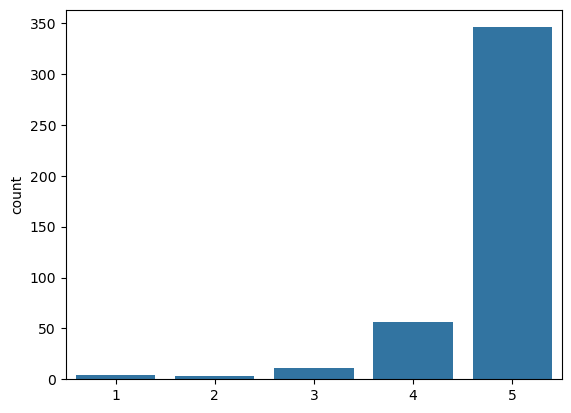

In [13]:
sns.countplot(x=stars_list);

### 3) 높은 평점 리뷰 저장

In [14]:
reviews_high = []
for i in review_list :
    if i['stars']==5 :
        # LLM학습에도 사용되고 있는 스페셜 토큰(START, END) 형식으로 한 리뷰의 시작과 끝을 구분하여
        # 모델이 더 잘 이해할 수 있도록 설정
        reviews_high.append('[REVIEW_START]'+i['review']+'[REVIEW_END]')

print(reviews_high[:5])

['[REVIEW_START]고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었네요.[REVIEW_END]', '[REVIEW_START]커피쿠폰도 받았구 깨끗하고 교회뷰도 이뻤어요!!![REVIEW_END]', '[REVIEW_START]잊을수없는 추억을 남겼어요 너무너무 좋았어요\r\n여자친구 몰래 프로포즈를 준비하게되었는데\r\n프론트 체크인 도와주셨던 직원분께 양해를 구하고\r\n선물을 미리 맡겨주셨고 프로포즈셋팅까지 완벽하게 진행될 수 있도록 정말 많은 도움 주셨어요\r\n바쁘신 와중에도 제가 계획한대로 체크인도 도와주셨고 딜라이브 ott까지 챙겨주시는 섬세함에 감동받았습니다 나중에 기념일때 다시한번 꼭 방문하겠습니다 성함을 기억했어야 하는데 젊은 남직원분\r\n다음번 방문때 감사인사 드리겠습니다\r\n훌륭한 룸컨디션도 칭찬합니다[REVIEW_END]', '[REVIEW_START]조식이 맛있어요!!다양하게 종류도 많구요 캠페인중이여서 할인도 해서 먹었는데 맛있습니다\n직원분들 친절하고 대응도 잘해주세요[REVIEW_END]', '[REVIEW_START]가족들이 간다고 해서 진짜 폭풍 검색해서 알아봐드렸는데 좋아하셔서 좋았습니다 :) 신라스테이는 어딜 가도 좋은것 같아요[REVIEW_END]']


In [15]:
# GPT의 prompt에 입력시 문자열 형태여야 하므로 리스트에 있는 리뷰들을 하나의 문자열로 합쳐주기
reviews_high_text = '\n'.join(reviews_high)

print(reviews_high_text[:500])

[REVIEW_START]고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었네요.[REVIEW_END]
[REVIEW_START]커피쿠폰도 받았구 깨끗하고 교회뷰도 이뻤어요!!![REVIEW_END]
[REVIEW_START]잊을수없는 추억을 남겼어요 너무너무 좋았어요
여자친구 몰래 프로포즈를 준비하게되었는데
프론트 체크인 도와주셨던 직원분께 양해를 구하고
선물을 미리 맡겨주셨고 프로포즈셋팅까지 완벽하게 진행될 수 있도록 정말 많은 도움 주셨어요
바쁘신 와중에도 제가 계획한대로 체크인도 도와주셨고 딜라이브 ott까지 챙겨주시는 섬세함에 감동받았습니다 나중에 기념일때 다시한번 꼭 방문하겠습니다 성함을 기억했어야 하는데 젊은 남직원분
다음번 방문때 감사인사 드리겠습니다
훌륭한 룸컨디션도 칭찬합니다[REVIEW_END]
[REVIEW_START]조식이 맛있어요!!다양하게 종류도 많구요 캠페


#### 4) 리뷰의 기간을 6개월로 설정하고 모든 전처리 단계를 함수화 시켜두기
- 야놀자 홈페이지에 요약한 후기는 최근 6개월간의 후기로 요약한 결과
- 우리들의 데이터는 24년10월16일 수집된 데이터로 그 이전 데이터들을 포함하고 있음
- 따라서 24년10월16일 부터 이전 6개월간의 동일한 기간의 데이터를 추출

In [33]:
import datetime
# dateutil : 다양한 형식의 날짜와 시간 문자열을 파싱하고 처리할 수 있는 모듈
# parser : 문자열에서 날짜와 시간 정보를 자동으로 인식하여 코드로 파싱하는 함수
from dateutil import parser

In [34]:
# 리뷰 데이터 전처리 함수
def preprocess_reviews(path="data/ya_review_sinla.json") :
    with open(path, "r", encoding="utf-8") as f :
        review_list = json.load(f)

    reviews_high = []

    # 기간 및 날짜 처리
    base_date = datetime.datetime(2024,10,16)

    # timedelta : 날짜 또는 시간 간의 차이를 구해주는 함수
     # 매개변수는 weeks, days, hours, minutes, seconds 등
     # base_date에서 최근 6개월(24주)간의 데이터의 기준 날짜를 설정
    date_boundary = base_date - datetime.timedelta(weeks=24)

    for i in review_list :
        # 각 리뷰의 날짜(년월일시)를 문자열로 변수에 저장
        review_date_str = i['date']
        try :
            # parse : 문자열을 날짜 타입으로 변경시켜주는 함수
            review_date = parser.parse(review_date_str)
        # 만약 ValueError, TypeError가 발생한다면 (년월일로 표시되지 않은 값들을 parse 함수 사용시 해당 에러가 발생)
        except (ValueError, TypeError) :
            # '~일 전' 이라는 리뷰들은 최근 6개월내에 반드시 포함되기 때문에 그냥 현재 날짜로 변경해도 무방
            review_date = base_date

        # 해당 리뷰의 날짜가 6개월 전 날짜보다 작다면(이전이라면) 후속 작업 없이 넘어감
        if review_date < date_boundary :
            continue

        if i['stars']==5 :
            reviews_high.append('[REVIEW_START]'+i['review']+'[REVIEW_END]')

    reviews_high_text = '\n'.join(reviews_high)

    return reviews_high_text    # 모든 전처리가 끝난 리뷰 데이터 문자열로 반환

In [35]:
datetime.datetime(2024,10,16) - datetime.timedelta(weeks=24)

datetime.datetime(2024, 5, 1, 0, 0)

### 3. 리뷰 문장 요약을 위한 Baseline 모델 개방
- base모델(gpt-3.5)이 야놀자 후기 요약 문장(gpt-4)에 근접하게 성능을 향상시켜보는 것이 우리의 목표!

In [36]:
reviews = preprocess_reviews()   # 디폴트 경로는 신라호텔 데이터의 경로

In [38]:
len(reviews)

6916

In [39]:
# 기준이 되는 베이스 프롬프트를 시작으로 점점 고도화 시켜나갈 예정
PROMPT_BASELINE = "아래 숙소 리뷰에 대해 5문장 내로 요약해줘."

#### 1) 리뷰 요약 함수 선언

In [40]:
def summarize(reviews, prompt, temperature=0, model='gpt-3.5-turbo') :
    prompt = prompt + '\n\n' + reviews

    completion = client.chat.completions.create(model=model,
                                                messages=[{'role':'user', 'content':prompt}],
                                                temperature=temperature
                                               )
    return completion.choices[0].message.content

#### 2) 모델별 요약 결과

In [23]:
# base 모델 요약 결과(gpt-3.5-turbo)
print(summarize(reviews, PROMPT_BASELINE))

조식포함으로 결정한 숙소는 시설, 서비스, 청결도 모두 만족스러웠고, 직원분들도 친절하고 조식이 맛있었다. 가족들이 좋아하셔서 만족스러웠고, 깨끗하고 친절한 숙소였다. 위치도 좋고 주차도 편리했으며, 다양한 음식점이 주변에 있어서 편리했다. 룸 컨디션은 5성급 호텔과 비슷한 수준이었고, 주차 스트레스 없이 편안하게 묵을 수 있었다.


In [24]:
# 야놀자 홈페이지 높은 평점 후기 요약 결과(gpt-4-turbo)
summary_gpt4_turbo = """청결하고 쾌적한 환경을 제공하며, 친절한 직원 서비스가 돋보입니다.
조식은 다양한 메뉴와 맛으로 손님들에게 호평을 받으며, 주차 시설도 편리하게 마련되어 있습니다.
객실은 아늑하고 고급스러운 분위기를 연출하며, 일부 객실에서는 도로 소음이 발생할 수 있습니다.
접근성과 주변 식당, 카페가 다양해 이용객의 편의성이 높습니다. 전반적으로 가성비가 우수하고, 재방문 의사가 있는 곳입니다."""
summary_gpt4_turbo

'청결하고 쾌적한 환경을 제공하며, 친절한 직원 서비스가 돋보입니다.\n조식은 다양한 메뉴와 맛으로 손님들에게 호평을 받으며, 주차 시설도 편리하게 마련되어 있습니다.\n객실은 아늑하고 고급스러운 분위기를 연출하며, 일부 객실에서는 도로 소음이 발생할 수 있습니다.\n접근성과 주변 식당, 카페가 다양해 이용객의 편의성이 높습니다. 전반적으로 가성비가 우수하고, 재방문 의사가 있는 곳입니다.'

### 4. 모델 평가 함수 선언
#### 1) 평가 기준 설정
- MT-Bench 논문 기반 Pairwise Comparision 방식 사용
  - LLM기반 응답 품질 비교 평가
  - gpt-4o 모델을 활용하여 2개 모델(3.5-turbo, 4turbo)의 요약 결과를 비교 평가해보자

#### 2) 평가를 위한 스크립트 및 모델 실행 코드 작성
- 기존 MT-Bench 논문의 평가용 프롬포트에서 우리의 task에 맞게 일부만 수정한 프롬포트를 활용

In [41]:
def pairwise_eval(reviews, answer_a, answer_b) :
    eval_prompt = f"""[System]
Please act as an impartial judge and evaluate the quality of the Korean summaries provided by two
AI assistants to the set of user reviews on accommodations displayed below. You should choose the assistant that
follows the user's instructions and answers the user's question better. Your evaluation
should consider factors such as the helpfulness, relevance, accuracy, depth, creativity,
and level of detail of their responses. Begin your evaluation by comparing the two
responses and provide a short explanation. Avoid any position biases and ensure that the
order in which the responses were presented does not influence your decision. Do not allow
the length of the responses to influence your evaluation. Do not favor certain names of
the assistants. Be as objective as possible. After providing your explanation, output your
final verdict by strictly following this format: "[[A]]" if assistant A is better, "[[B]]"
if assistant B is better, and "[[C]]" for a tie.
[User Reviews]
{reviews}
[The Start of Assistant A's Answer]
{answer_a}
[The End of Assistant A's Answer]
[The Start of Assistant B's Answer]
{answer_b}
[The End of Assistant B's Answer]"""

    # 평가를 위한 LLM은 gpt-4o 버전으로 지정
    completion = client.chat.completions.create(model='gpt-4o',
                                               messages=[{'role':'user', 'content':eval_prompt}],
                                               temperature=0
                                               )
    return completion.choices[0].message.content

#### 3) bsae모델(gpt-3.5)과 gpt4모델 하나씩의 응답에 대해 시범 평가

In [42]:
# base모델 응답
answer_a = summarize(reviews, PROMPT_BASELINE)

In [43]:
# 평가 함수 실행
print(pairwise_eval(reviews, answer_a, summary_gpt4_turbo))

Assistant A's summary is concise and captures the essence of the user reviews by highlighting the positive aspects of the accommodation, such as the quality of breakfast, facilities, service, and cleanliness. It also mentions the friendliness of the staff and the desire to revisit, which aligns well with the overall sentiment of the reviews.

Assistant B's summary, on the other hand, provides a more detailed overview, covering various aspects such as cleanliness, staff service, breakfast quality, parking facilities, room ambiance, noise issues, accessibility, and value for money. This response offers a broader perspective on the accommodation, addressing both positive and potential negative aspects, which could be more informative for someone considering staying there.

While Assistant A's response is accurate and relevant, Assistant B's response provides a more comprehensive and detailed summary, making it more helpful for potential guests.

[[B]]


### 5. 메인 평가 진행
- 실무에서는 다양한 데이터에 대해 더 많은 횟수로 평가하지만 지금은 그렇게 하기 힘들기 때문에 동일한 prompt에 대해 temperature를 높여서 다양한 응답을 10개 만들어서 비교 평가를 진행!
- 경험상 50~100번 정도의 평가를 진행하면 좋지만 시간과 비용의 문제로 우리는 일단 10번 정도로 제한해서 진행!

In [46]:
# temperature를 0.8 로 설정하고 10번의 요약 결과를 리스트에 담기
summaries_baseline = [summarize(reviews, PROMPT_BASELINE, temperature=0.8) for _ in range(10)]
summaries_baseline

['다양한 음식을 즐길 수 있는 조식포함으로 만족한 숙소. 친절한 직원과 깨끗한 시설, 편리한 주차장이 좋았다.',
 '조식포함으로 결정한 숙소는 만족스럽고 좋았다. 직원들은 친절하고 시설, 서비스, 청결도 모두 훌륭했다.',
 '좋은 조식포함 숙소 선택, 만족스러운 시설과 서비스, 깨끗한 숙소.',
 '조식포함으로 결정한 것은 좋은 선택이었고, 조식도 만족스러웠으며 시설, 서비스, 청결도 모두 좋았다. 직원분들도 친절하고 대응도 잘해준다. 또한, 깨끗하고 친절한 서비스를 받아 만족스러웠다. 위치도 좋고 조식도 맛있었으며, 주차도 편리한 곳이라고한다. 침구와 조식이 좋았고, 직원분들의 친절한 서비스로 편안하게 쉬다갔다고 한다.',
 '조식포함으로 결정한 숙소는 좋은 선택이었고, 조식이 맛있고 시설, 서비스, 청결도 모두 만족스러웠다. 직원은 친절하고 대응도 잘해주었고, 숙소는 청결하고 깨끗했다. 위치도 편리하고 가성비가 좋은 편이었으며, 다음에도 재방문 의사가 있다.',
 '조식 포함으로 결정한 숙소는 시설, 서비스, 청결도가 나무랄데가 없었고, 다양한 조식과 할인이 좋았으며, 가족들도 만족스러워했다. 프론트 직원은 친절했고, 교통편도 편리했으며, 청결하고 조식이 맛있었다.객실은 5성급 호텔 수준이었으며, 위치가 좋았고, 편리한 주차장을 갖췄다. 다양한 음식을 제공하는 조식은 가성비 괜찮았고, 직원들은 친절했다. 객실은 깨끗하고 침구도 편안했으며, 편안하게 쉬다 갈 수 있었다.',
 '조식 포함으로 결정한 숙소는 시설, 서비스, 청결도 모두 만족스러웠고, 조식이 맛있고 다양했다. 함께 간 이들도 만족했으며, 직원들이 친절하고 대응도 좋았다. 숙소는 깨끗하고 편안하게 쉬었으며, 주차도 편리했다. 위치도 좋고, 조식이 맛있어서 다시 방문할 의사가 있다.',
 '조식포함으로 결정한 숙소는 시설, 서비스, 청결도 모두 좋았고, 조식이 맛있었다고 함. 직원분들도 친절하고 대응도 좋았다고 함. 가격대비 성능이 좋았고, 위치도 좋았다고 함. 깨끗하고 친절한 숙소로 편안하게

In [47]:
len(summaries_baseline)

10

In [30]:
# gpt-4 모델도 비교를 위해 10번을 리스트에 넣기
summaries_gpt4 = [summary_gpt4_turbo for _ in range(10)]
summaries_gpt4

['청결하고 쾌적한 환경을 제공하며, 친절한 직원 서비스가 돋보입니다.\n조식은 다양한 메뉴와 맛으로 손님들에게 호평을 받으며, 주차 시설도 편리하게 마련되어 있습니다.\n객실은 아늑하고 고급스러운 분위기를 연출하며, 일부 객실에서는 도로 소음이 발생할 수 있습니다.\n접근성과 주변 식당, 카페가 다양해 이용객의 편의성이 높습니다. 전반적으로 가성비가 우수하고, 재방문 의사가 있는 곳입니다.',
 '청결하고 쾌적한 환경을 제공하며, 친절한 직원 서비스가 돋보입니다.\n조식은 다양한 메뉴와 맛으로 손님들에게 호평을 받으며, 주차 시설도 편리하게 마련되어 있습니다.\n객실은 아늑하고 고급스러운 분위기를 연출하며, 일부 객실에서는 도로 소음이 발생할 수 있습니다.\n접근성과 주변 식당, 카페가 다양해 이용객의 편의성이 높습니다. 전반적으로 가성비가 우수하고, 재방문 의사가 있는 곳입니다.',
 '청결하고 쾌적한 환경을 제공하며, 친절한 직원 서비스가 돋보입니다.\n조식은 다양한 메뉴와 맛으로 손님들에게 호평을 받으며, 주차 시설도 편리하게 마련되어 있습니다.\n객실은 아늑하고 고급스러운 분위기를 연출하며, 일부 객실에서는 도로 소음이 발생할 수 있습니다.\n접근성과 주변 식당, 카페가 다양해 이용객의 편의성이 높습니다. 전반적으로 가성비가 우수하고, 재방문 의사가 있는 곳입니다.',
 '청결하고 쾌적한 환경을 제공하며, 친절한 직원 서비스가 돋보입니다.\n조식은 다양한 메뉴와 맛으로 손님들에게 호평을 받으며, 주차 시설도 편리하게 마련되어 있습니다.\n객실은 아늑하고 고급스러운 분위기를 연출하며, 일부 객실에서는 도로 소음이 발생할 수 있습니다.\n접근성과 주변 식당, 카페가 다양해 이용객의 편의성이 높습니다. 전반적으로 가성비가 우수하고, 재방문 의사가 있는 곳입니다.',
 '청결하고 쾌적한 환경을 제공하며, 친절한 직원 서비스가 돋보입니다.\n조식은 다양한 메뉴와 맛으로 손님들에게 호평을 받으며, 주차 시설도 편리하게 마련되어 있습니다.\n객실은 아늑하고 고급스

In [31]:
# 10번씩 평가함수 설정(gpt3.5모델이 4모델에 비해 얼마나 승리했는지 출력)
def pairwise_eval_batch(reviews, answers_a, answers_b) :
    a_cnt, b_cnt, c_cnt = 0,0,0 # 승리, 패배, 무승부

    for i in tqdm(range(10)) :
        result_text = pairwise_eval(reviews, answers_a[i], answers_b[i])
        
        # 평가 함수로 평가한 응답 중에 [[A]]가 있다면 (즉, gpt3.5가 요약을 더 잘했다면)
        if '[[A]]' in result_text :
            a_cnt += 1
        # gpt4가 더 요약을 잘했다면
        elif '[[B]]' in result_text :
            b_cnt += 1
        # 두 모델이 동일한 요약 성능이라면
        elif '[[C]]' in result_text :
            c_cnt += 1
        else :
            print("응답 에러 발생~~ ㅠㅡㅠ")

    return a_cnt, b_cnt, c_cnt

In [32]:
wins, losses, ties = pairwise_eval_batch(reviews, summaries_baseline, summaries_gpt4)
print(f"Wins: {wins}, Losses: {losses}, Ties:{ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.24s/it]

Wins: 1, Losses: 9, Ties:0


- base 모델로 10번 비교 평가시 base모델의 패배가 훨씬 많은 상태

### 6. 모델 및 프롬포트 고도화

#### 1) 프롬포트 엔지니어링(페르소나 및 조건 명시)

In [48]:
prompt = """당신은 문장 요약 전문가 입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요약하는 것이 당신의 임무 입니다.

요약 결과는 다음 조건들을 충족해야 합니다:
1. 모든 문장은 항상 존댓말로 끝나야 합니다.
2. 숙소에 대해 소개하는 톤앤매너로 작성해주세요.
 2-1. 좋은 리뷰 요약 예시
    a) 전반적으로 좋은 숙소였고 방음도 괜찮았다는 평입니다.
    b) 재방문 예정이라는 평들이 존재합니다.
 2-2. 나쁜 리뷰 요약 예시
    a) 좋은 숙소였고 방음도 괜찮음
    b) 재방문 예정
3. 요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성해주세요.

아래 숙소 리뷰들에 대해 요약해주세요:
"""
# 변경한 프롬프트를 넣어 gpt-3.5-turbo모델로 10번의 요약 실행
summaries_opti1 = [summarize(reviews, prompt, temperature=0.8) for _ in range(10)]

In [49]:
# 1차 변경한 프롬프트로 요약한 결과와 기존 gpt-4-turbo모델의 결과를 10회 비교
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti1, summaries_gpt4)
print(f"Wins: {wins}, Losses: {losses}, Ties:{ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.40s/it]

Wins: 6, Losses: 4, Ties:0


#### 2) 입력데이터의 품질 향상
- 실제 숙소에 대한 정보가 포함되지 않는 단순하고 짧은 리뷰들은 필터링하기 ex) 좋았어요. 굳굳 등
- 우리가 해결하고자하는 문제(task)에 따라서 입력데이터의 품질에 대한 기준은 달라질 수 있음

In [51]:
# 짧은 리부 데이터들을 필터링할 수 있는 전처리 함수
def preprocess_reviews(path="data/ya_review_sinla.json") :
    with open(path, "r", encoding="utf-8") as f :
        review_list = json.load(f)

    reviews_high = []

    base_date = datetime.datetime(2024,10,16)
    date_boundary = base_date - datetime.timedelta(weeks=24)

    filtered_cnt = 0   # 필터링 된 리뷰 개수 카운트용
    
    for i in review_list :

        review_date_str = i['date']
        try :

            review_date = parser.parse(review_date_str)

        except (ValueError, TypeError) :
   
            review_date = base_date

        if review_date < date_boundary :
            continue

        # 리뷰의 길이가 15자 미만이면 다시 되돌아가게 설정
        if len(i['review']) < 15 :
            filtered_cnt += 1
            continue

        
        if i['stars']==5 :
            reviews_high.append('[REVIEW_START]'+i['review']+'[REVIEW_END]')

    # 사용할 리뷰 개수를 최대 50개까지만 지정(gpt-3.5모델의 경우 토큰수의 제한이 크지 않아서 입력이 너무 길면 에러가 발생)
     # min함수를 사용하여 10자 이상인 리뷰들의 개수가 50개보다 적다면 해당 개수만큼만 사용하고, 더 많아도 50개까지만 사용하도록 지정
    reviews_high = reviews_high[ : min(len(reviews_high), 50)]

    print("10자 미만 리뷰 개수 :", filtered_cnt)
    print("필터링 되고 남은 높은 평점 리뷰 개수 :", len(reviews_high))

    reviews_high_text = '\n'.join(reviews_high)

    return reviews_high_text   

In [52]:
# 변경된 전처리 함수를 리뷰데이터에 다시적용
reviews = preprocess_reviews()

10자 미만 리뷰 개수 : 42
필터링 되고 남은 높은 평점 리뷰 개수 : 50


In [102]:
# 프롬프팅 + 데이터 필터링이 적용된 요약 결과
summaries_opti2 = [summarize(reviews, prompt, temperature=0.8) for _ in range(20)]

KeyboardInterrupt: 

In [55]:
# 평가
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti2, summaries_gpt4)
print(f"Wins: {wins}, Losses: {losses}, Ties:{ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.64s/it]

Wins: 5, Losses: 5, Ties:0


- 입력데이터의 품질을 올려주는 것만으로도 조금 더 성능의 향상을 볼 수 있음

#### 3) Few-shot learning
- 질의-응답 쌍의 예시를 들어주기 위해 **새로운 숙소의 리뷰와 그 요약을 예시**로 넣어주자

In [56]:
# one-shot

# 요약 예시문으로 활용하기 위한 글래드 강남 코엑스센터 호텔의 리뷰를 불러와서 전처리 진행
reviews_1shot = preprocess_reviews('data/ya_review_glad.json')

# 요약 예시문 생성(좀 더 좋은 예시를 위해 상급 모델활용)
summary_1shot = summarize(reviews_1shot, prompt, temperature=0, model='gpt-4o')
summary_1shot

10자 미만 리뷰 개수 : 56
필터링 되고 남은 높은 평점 리뷰 개수 : 50


'글래드 삼성 호텔은 편리한 위치와 깔끔한 시설로 많은 고객들에게 사랑받고 있습니다. 삼성역과 가까워 교통이 편리하며, 코엑스와 현대백화점 등 주요 명소와의 접근성도 뛰어납니다. 침구가 매우 편안하다는 평이 많아 숙박 시 편안한 휴식을 취할 수 있습니다. 직원들의 친절한 서비스와 다양한 부대시설도 고객 만족도를 높이는 요소로 작용하고 있습니다. 다만, 일부 고객들은 소음 문제를 언급하기도 했으나, 전반적으로 긍정적인 평가가 주를 이루고 있습니다.'

In [57]:
reviews_1shot

'[REVIEW_START]편리하고 깨끗한 시설이 좋았습니다[REVIEW_END]\n[REVIEW_START]가족과 함께 묵었습니다. 아주 편안하게 이용했습니다.\n침대도 부드럽고 청결하고, 욕실도 깨끗했습니다.[REVIEW_END]\n[REVIEW_START]체크인\n체크인 시간보다 일찍 가도 얼리 체크인이 가능해서 빠르게 일정을 준비할 수 있어서 좋았습니다.\n방 컨디션\n방은 호텔이라는 이름에 맞게 상당히 깔끔하게 준비되어 있었습니다 크기는 2명에 사용하기 적당하다고 생각되고 환기가 가능한 창문이 있어서 좋았지만 뷰는 일반적인 도로뷰 입니다.\n침구, 서비스\n침구는 상당히 좋았던 경험입니다 숙박기간동안 잠을 정말 잘잤으며 이불도 푹신하고 깔끔해서 좋은 기분으로 잠을 잘 수 있었습니다 호텔리어분들의 친철함과 캐리어 보관 서비스 또한 정말 좋고 로봇을 활용한 서비스와 특별한 경험을 했습니다\n기타 \n룸서비스는 따로 없지만 지하에 일식집과 양식집이 있어서 이용하기 좋았고 바로 앞에 삼성역이 있어서 교통적으로 이점과 코엑스가 가까워 상당한 지리적인 이점이 있다고 생각되는곳입니다~[REVIEW_END]\n[REVIEW_START]명불허전 글래드 최고입니다![REVIEW_END]\n[REVIEW_START]글래드삼성 위치도 좋고 무엇보다 침구가 너무 편안합니다. :) 편안한 숙박이었어요.\n응대도 친절합니다.[REVIEW_END]\n[REVIEW_START]방이 그다지 넓진 않고\n삼성역이 장기공사중이라 뷰도 기대할 건 없지만\n체크인이 간편하고 침구도 깔끔하고\n요청사항도 잘 반영해주셔서 편안하게 이용했습니다[REVIEW_END]\n[REVIEW_START]항상 호캉스 하고싶을때 가요! 지하에 있는 식당들도 맛있고, 코엑스나 맛집들과도 가까워서 편해요! 방 상태도 깨끗하고, 낮잠도 자고 쉬고 OTT 보기에 너무 좋습니다 :)[REVIEW_END]\n[REVIEW_START]브랜드 명성답게 호텔 퀄리티 좋았으며, 전망도 탁트인 창은 아니었느나 매우 훌륭했습니다.

In [58]:
prompt_1shot = f"""당신은 문장 요약 전문가 입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요약하는 것이 당신의 임무 입니다.

요약 결과는 다음 조건들을 충족해야 합니다:
1. 모든 문장은 항상 존댓말로 끝나야 합니다.
2. 숙소에 대해 소개하는 톤앤매너로 작성해주세요.
 2-1. 좋은 리뷰 요약 예시
    a) 전반적으로 좋은 숙소였고 방음도 괜찮았다는 평입니다.
    b) 재방문 예정이라는 평들이 존재합니다.
 2-2. 나쁜 리뷰 요약 예시
    a) 좋은 숙소였고 방음도 괜찮음
    b) 재방문 예정
3. 요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성해주세요.

다음은 참고할 리뷰들과 그에 대한 요약 예시입니다.

[예시 리뷰들] :
{reviews_1shot}
[예시 요약 결과] :
{summary_1shot}

아래 숙소 리뷰들에 대해 요약해주세요:
"""

summaries_opti3 = [summarize(reviews, prompt_1shot, temperature=0.8) for _ in range(10)]

In [59]:
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti3, summaries_gpt4)
print(f"Wins: {wins}, Losses: {losses}, Ties:{ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.50s/it]

Wins: 9, Losses: 1, Ties:0


- one-shot 이후 결과가 다시 안좋아짐
- few-shot learning을 사용한다고 무조건 좋아지는 것은 아니며 프롬프트의 조건과 few-shot의 예시가 잘 안맞거나 너무 복잡해서 난해한 경우 모델이 해당 예시를 잘 참조하지 못할 수도 있음
- Prompt Enginnering은 테스트의 영역!

#### 프롬프트의 조건부분을 단순화 시켜서 프롬프팅을 진행해보자!

In [81]:
prompt_1shot_ver2 = f"""당신은 문장 요약 전문가 입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요약하는 것이 당신의 임무 입니다.

요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성해주세요.

다음은 참고할 리뷰들과 그에 대한 요약 예시입니다.

[예시 리뷰들] :
{reviews_1shot}
[예시 요약 결과] :
{summary_1shot}

아래 숙소 리뷰들에 대해 요약해주세요:
"""

summaries_opti4 = [summarize(reviews, prompt_1shot_ver2, temperature=0.8) for _ in range(10)]

In [82]:
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti4, summaries_gpt4)
print(f"Wins: {wins}, Losses: {losses}, Ties:{ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.61s/it]

Wins: 10, Losses: 0, Ties:0


#### Two-shot learning으로 조금 더 많은 예시를 줘보자
1. 호텔 인 나인(in9) 리뷰 파일 로드 후 전처리
2. 요약 결과 출력(temprature=0, model='gpt-4o')
3. 호텔 인 나인 리뷰와 요약 결과를 새로운 프롬프트(변수명:prompt_2shot)에 넣어서 two-shot으로 구성
4. 10번의 반복 요약(변수명:summaries_opti5)
5. 최종 평가

In [83]:
# 1,2 번
reviews_2shot = preprocess_reviews('data/ya_review_in9.json')
summary_2shot = summarize(reviews_1shot, prompt, temperature=0, model='gpt-4o')
summary_2shot

10자 미만 리뷰 개수 : 42
필터링 되고 남은 높은 평점 리뷰 개수 : 46


'글래드 삼성 호텔은 편리한 위치와 깔끔한 시설로 많은 고객들에게 사랑받고 있습니다. 삼성역과 가까워 교통이 편리하며, 코엑스와 현대백화점 등 주요 명소와의 접근성도 뛰어납니다. 침구가 매우 편안하다는 평이 많아 숙박 시 편안한 휴식을 취할 수 있습니다. 직원들의 친절한 서비스와 다양한 부대시설도 고객 만족도를 높이는 요소로 작용하고 있습니다. 다만, 일부 고객들은 소음 문제를 언급하기도 했으나, 전반적으로 긍정적인 평가가 주를 이루고 있습니다.'

In [86]:
prompt_2shot = f"""당신은 문장 요약 전문가 입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요약하는 것이 당신의 임무 입니다.

요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성해주세요.

다음은 참고할 리뷰들과 그에 대한 요약 예시입니다.

[예시 리뷰들1] :
{reviews_1shot}
[예시 요약 결과1] :
{summary_1shot}

[예시 리뷰들2] :
{reviews_2shot}
[예시 요약 결과2] :
{summary_2shot}


아래 숙소 리뷰들에 대해 요약해주세요:
"""

summaries_opti5 = [summarize(reviews, prompt_2shot, temperature=0.8) for _ in range(10)]

In [87]:
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti5, summaries_gpt4)
print(f"Wins: {wins}, Losses: {losses}, Ties:{ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.82s/it]

Wins: 7, Losses: 3, Ties:0


### [실습] 자유롭게 프롬포트 및 데이터 전처리를 변경하여 성능을 높여보세요
- 평가 횟수는 20번으로 상향(3.5turbo 및 4-turbo 모두 20개씩 요약하고 평가 횟수도 20번으로 상향)
- ChatGPT나 외부 소프트웨어 도움없이 직접 프롬포트 및 데이터를 변경할 것
- 가장 Wins가 높을 때의 결과 및 코드 캡쳐

In [94]:
# 4-turbo
summaries_gpt4_20 = [summary_gpt4_turbo for _ in range(20)]

In [95]:
reviews_3shot = preprocess_reviews('data/ya_review_glad.json')
summary_3shot = summarize(reviews_1shot, prompt, temperature=0, model='gpt-4o')
summary_3shot

10자 미만 리뷰 개수 : 56
필터링 되고 남은 높은 평점 리뷰 개수 : 50


'글래드 삼성 호텔은 편리한 위치와 깔끔한 시설로 많은 고객들에게 사랑받고 있습니다. 삼성역과 가까워 교통이 편리하며, 코엑스와 현대백화점 등 주요 명소와의 접근성도 뛰어납니다. 침구가 매우 편안하다는 평이 많아 숙박 시 편안한 휴식을 취할 수 있습니다. 직원들의 친절한 서비스와 다양한 부대시설도 고객 만족도를 높이는 요소로 작용하고 있습니다. 다만, 일부 고객들은 소음 문제를 언급하기도 했으나, 전반적으로 긍정적인 평가가 주를 이루고 있습니다.'

In [105]:
prompt_3shot = f"""당신은 아주 뛰어난 문장 요약 전문가 입니다. 사용자 숙소 리뷰들이 주어지면 이를 요약하는 것이 당신의 임무 입니다.

요약 결과는 다음 조건들을 충족해야 합니다. :
1. 최소 4문장 이상 최대 7문장 이내로 작성해주세요.
2. 시설, 긍정적인 키워드 이야기가 나오면 좋고 ('시설'이라는) 단어를 말하는 것이 아닌 당신이 판단하였을 때의 그 시설, 긍정 키워드를 말하는 것입니다.
3. 많이 들어간 단어를 뽑아도 좋고 그중에서 너가 판단했을 떄 필터링 해서 요약 키워드 뽑아서 문장을 만들어야 합니다.

다음은 참고할 리뷰들과 그에 대한 요약 예시입니다.

[예시 리뷰들1] :
{reviews_1shot}
[예시 요약 결과1] :
{summary_1shot}

[예시 리뷰들2] :
{reviews_2shot}
[예시 요약 결과2] :
{summary_2shot}


아래 숙소 리뷰들에 대해 요약해주세요:
"""

summaries_opti6 = [summarize(reviews, prompt_3shot, temperature=0.8) for _ in range(20)]

In [106]:
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti6, summaries_gpt4_20)
print(f"Wins: {wins}, Losses: {losses}, Ties:{ties}")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.94s/it]

Wins: 5, Losses: 5, Ties:0
